# ****Hyperparameter Tuning****

## **Plan Of Action** :  
1. **Number Of Hidden Layers**  
2. **Neurons Per Layer**  
3. **Number Of Epochs**  
4. **Optimizer**  
5. **Learning Rate**
6. **Batch Size**
7. **Droupout Layer**
8. **Weight Decay (lambda)**

# ****Import Libraries****

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import optuna


from sklearn.model_selection import train_test_split
import kagglehub

## ****Set Random Seed****

In [ ]:
# Set random seeds for Repoductibility
torch.manual_seed(42)

## ****Check GPU Availability****

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device name :\t{device}')

Device name :	cuda


# ****Import Data****

In [ ]:
path = kagglehub.dataset_download("zalando-research/fashionmnist", path = 'fashion-mnist_train.csv')

df = pd.read_csv(path)

Using Colab cache for faster access to the 'fashionmnist' dataset.


# ****Visualization of Data****

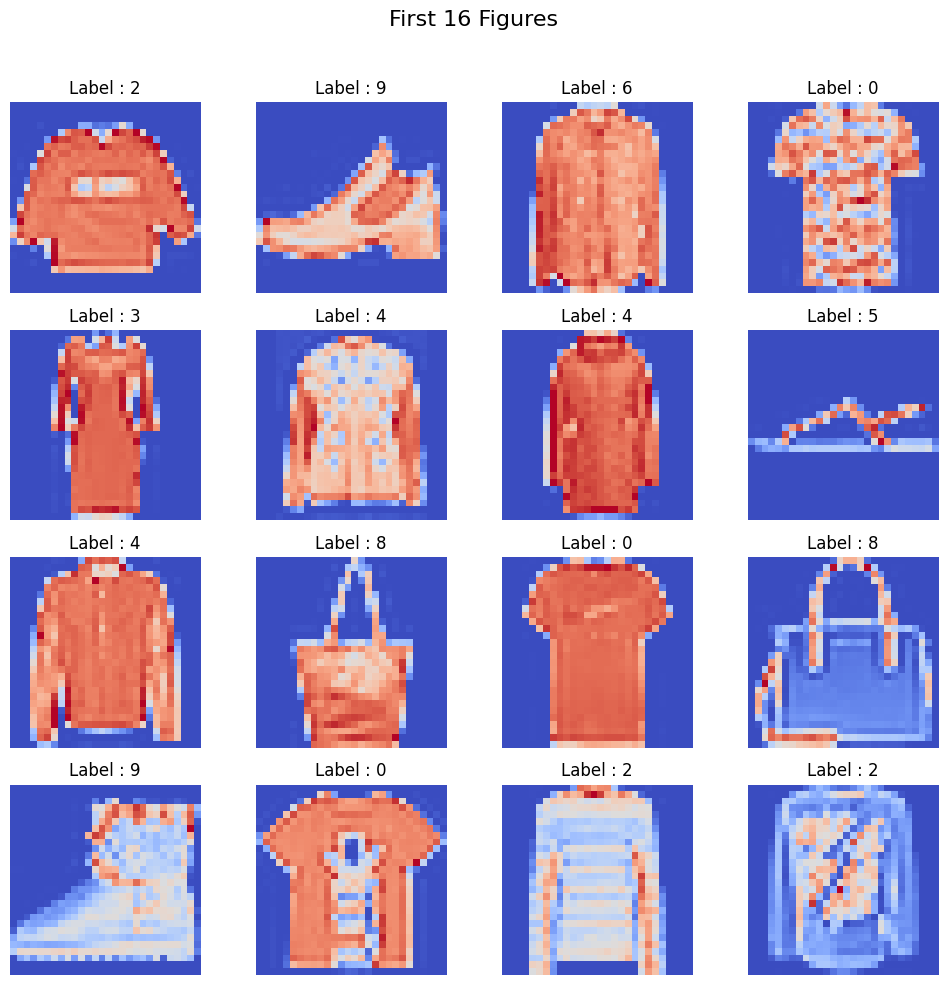

In [ ]:
fig, axis = plt.subplots(4, 4, figsize = (10, 10))
fig.suptitle('First 16 Figures', fontsize = 16)                                                           # create 4 x 4 grid of images

for i, ax in enumerate(axis.flat):
  img = df.iloc[i, 1:].values.reshape(28, 28)                                                             # Reshape the data for image plot
  ax.imshow(img, cmap = 'coolwarm')                                                                       # Display image
  ax.axis('off')                                                                                          # Remove axis
  ax.set_title(f'Label : {df.iloc[i, 0]}')

plt.tight_layout(rect = [0, 0, 1, 0.96])
plt.show()

# ****Split Data in Train and test****

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

# ****Make Class CustomDataset and use DataLoader****

## ****Dataset****

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):
    self.features = torch.tensor(features, dtype = torch.float32)
    self.labels = torch.tensor(labels, dtype = torch.long)

  def __len__(self):

    return len(self.features)

  def __getitem__(self, idx):

    return self.features[idx], self.labels[idx]

In [ ]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

## ****Hyperparameter Tuning****

In [ ]:
class MyNN(nn.Module):

  def __init__(self, input_dim, out_dim, num_hidden_layers, neurons_per_layer, droupout_rate):

    super().__init__()

    layers = []

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(droupout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, out_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):

    return self.model(x)

In [ ]:
# Objective Function
def objective(trial):

  # Next Hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 5)
  neurons_per_layer = trial.suggest_int('neurons_per_layer', 8, 128, step = 8)
  epochs = trial.suggest_int('epochs', 10, 50, step = 10)
  learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log = True)
  dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step = 0.1)
  batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical('optimizer_name', ['Adam', 'AdamW', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log = True)

  # Data Loader
  train_loader = DataLoader(train_dataset, batch_size = batch_size, pin_memory = True, shuffle = True)
  test_loader = DataLoader(test_dataset, batch_size = batch_size, pin_memory = True, shuffle = False)

  # Model Init
  input_dim = 784
  out_dim = 10

  model = MyNN(input_dim, out_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # Optimizer Selection
  criterion = nn.CrossEntropyLoss()

  if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

  elif optimizer_name == 'AdamW':
    optimizer = optim.AdamW(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

  elif optimizer_name == "SGD":
    optimizer = optim.SGD(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

  elif optimizer_name == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

  # Training loop
  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # Move to GPU
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # Forward Pass
      outs = model(batch_features)

      # Calculate Loss
      loss = criterion(outs, batch_labels)

      # Back Pass
      optimizer.zero_grad()
      loss.backward()

      # Update Grads
      optimizer.step()

  # Evaluation
  model.eval()

  # Evaluation on test Data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # Move to GPU
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # Forward Pass
      outs = model(batch_features)

      # Preds
      _, preds = torch.max(outs, 1)

      total += batch_labels.shape[0]

      correct += (preds == batch_labels).sum().item()

    accuracy = np.round((correct / total), 4)

  return accuracy

In [ ]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 10)

[I 2026-02-08 06:29:17,167] A new study created in memory with name: no-name-5232aed2-cf91-411a-9c1c-8810d51714fe
[I 2026-02-08 06:30:46,449] Trial 0 finished with value: 0.8868 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 96, 'epochs': 50, 'learning_rate': 1.7163764296352327e-05, 'dropout_rate': 0.1, 'batch_size': 128, 'optimizer_name': 'RMSprop', 'weight_decay': 8.355811602393703e-05}. Best is trial 0 with value: 0.8868.
[I 2026-02-08 06:33:14,941] Trial 1 finished with value: 0.8411 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 32, 'epochs': 20, 'learning_rate': 0.012786960492362958, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_name': 'SGD', 'weight_decay': 0.00032228313176795715}. Best is trial 0 with value: 0.8868.
[I 2026-02-08 06:34:58,455] Trial 2 finished with value: 0.8548 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 16, 'epochs': 40, 'learning_rate': 0.06915067210802912, 'dropout_rate': 0.30000000000000004, 'batch_size':

In [ ]:
study.best_value

0.8918

In [ ]:
study.best_params

{'num_hidden_layers': 4,
 'neurons_per_layer': 80,
 'epochs': 40,
 'learning_rate': 0.00010914752767752645,
 'dropout_rate': 0.1,
 'batch_size': 64,
 'optimizer_name': 'AdamW',
 'weight_decay': 0.0002810767111570835}